# Problem 2 #
## Load the superbowl data ##

In [1]:
import json
#
# WA = ['Washington', 'WA','Seattle','Kirkland']
# MA = ['Massachusetts','MA','Boston']

# Loading file and analyze location
def is_from_washington(loc):
	return 'Washington' in loc or 'WA' in loc or  'Seattle' in loc or 'Kirkland' in loc

def is_from_massachusetts(loc):
	return 'Massachusetts' in loc or ' MA' in loc or 'Boston' in loc

# extracting tweet data
hashtag = '#superbowl'
fname = 'tweet_data/tweets_#superbowl.txt'

tweet_texts = []
tweet_label = []
i = 0

filestream = open(fname, 'r')
for line in filestream:
	tweet = json.loads(line)
	tweet_text = tweet['tweet']['text']

	user_location = tweet['tweet']['user']['location']
	if is_from_washington(user_location):
	    tweet_texts.append(tweet_text)
	    tweet_label.append(1)

	elif is_from_massachusetts(user_location):
	    tweet_texts.append(tweet_text)
	    tweet_label.append(-1)

filestream.close()

print len(tweet_texts)



52074


## Preprocess data with tokenizor and TfidfTransformer ##

In [19]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
import string
import nltk
import sklearn.metrics as smet
from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn import svm
import sklearn.metrics as smet
from sklearn.svm import SVC
from sklearn.preprocessing import normalize

def myTokenizer(text):
	# update stopwords with punctuations
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = text.lower()
    stopWords = set(string.punctuation)
    stopWords.update(set(stopwords.words('english')))
    # engStemmer = SnowballStemmer('english')
    wordnetLem = WordNetLemmatizer()
    processed_tokens = []
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stopWords and len(word) >=2]
    lemmatized = [wordnetLem.lemmatize(word) for word in filtered]
    tagged_sent = pos_tag(lemmatized)
    # postagged = [word for word, pos in tagged_sent if pos == 'NN' or pos == 'VBZ']
    processed_tokens.extend(lemmatized)
    return processed_tokens

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()
    lw = 2
    roc_auc = smet.auc(fpr,tpr)

    ax.plot(fpr, tpr, color='darkorange',lw=lw, label= 'area under curve = %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.grid(color='0.6', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
    plt.show()

def fit_predict_and_plot_roc(svm, train_data, train_label, test_data, test_label, prob_score):
#     svm.fit(train_data, train_label)
#     prob_score = svm.predict_proba(test_data)
    # fpr0, tpr0, _ = smet.roc_curve(test_label, prob_score[:, 0])
    fpr1, tpr1, _ = smet.roc_curve(test_label, prob_score[:,1])
    # fpr, tpr, threshhold = smet.roc_curve(test_label, prob_score)
    # plot_roc(fpr0, tpr0)
    plot_roc(fpr1, tpr1)
    return svm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
vectorizer = CountVectorizer(analyzer='word', tokenizer=myTokenizer, stop_words=stop_words)
tfidf_transformer = TfidfTransformer()
svd = TruncatedSVD(n_components=50, algorithm='arpack')
nmf = NMF(n_components=50, init='random', random_state=0)
normalizer = Normalizer(norm = 'l2', copy=False)


X_train, X_test, y_train, y_test = train_test_split(tweet_texts, tweet_label, train_size=0.9, random_state=42)
processing = Pipeline([('vect', vectorizer),
                ('tfidf', tfidf_transformer),
                ('svd', svd),
                ('norm', normalizer),
                ])
train_svd_data = processing.fit_transform(X_train)
test_svd_data = processing.fit_transform(X_test)







In [20]:
print train_svd_data

[[ 0.39054638 -0.31641689  0.16684694 ..., -0.032805    0.37558291
  -0.06024952]
 [ 0.5055817  -0.15011654  0.50383166 ...,  0.04431907  0.06487812
  -0.00095199]
 [ 0.43400821 -0.54227426  0.312774   ..., -0.04980662  0.01381138
  -0.06269887]
 ..., 
 [ 0.22545298 -0.17542915  0.130242   ...,  0.06549247 -0.05589468
   0.03388494]
 [ 0.34320987 -0.11526568 -0.12036607 ..., -0.08436398 -0.0108207
  -0.01043385]
 [ 0.23709246 -0.16538233  0.08558589 ..., -0.00827862 -0.04360026
  -0.02140211]]


## First model: Linear SVM with TruncatedSVD ##

In [26]:
print "Linear SVM SVD"
clf = SVC(kernel='linear', probability=True, C=0.025)
clf.fit(train_svd_data, y_train)


Linear SVM SVD


SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy:  0.652073732719
Recall:  0.753978779841
Precision:  0.680023923445
Confusion matrix:  [[1122 1070]
 [ 742 2274]]
F1 score:  0.715094339623


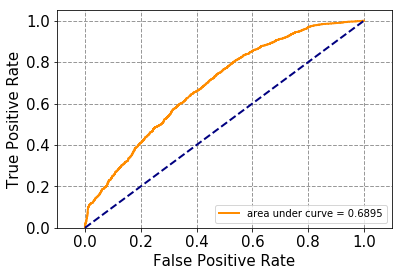

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
predicted_test_label = clf.predict(test_svd_data)
print "Accuracy: ", smet.accuracy_score(y_test, predicted_test_label)
print "Recall: ", smet.recall_score(y_test, predicted_test_label)
print "Precision: ", smet.precision_score(y_test, predicted_test_label)
print "Confusion matrix: ", smet.confusion_matrix(y_test, predicted_test_label)
print "F1 score: ", smet.f1_score(y_test, predicted_test_label)
prob_score = clf.predict_proba(test_svd_data)
fit_predict_and_plot_roc(clf, train_svd_data, y_train, test_svd_data, y_test, prob_score)

## Second model: Naive Bayes with NMF ##

In [15]:
print "Naive Bayes NMF"
processing_nmf = Pipeline([('vect', vectorizer),
                ('tfidf', tfidf_transformer),
                ('nmf', nmf),
                ('norm', normalizer),
                ])

train_nmf_data = processing_nmf.fit_transform(X_train)
test_nmf_data = processing_nmf.fit_transform(X_test)



Naive Bayes NMF


In [16]:
print train_nmf_data


[[  9.37814883e-03   4.17638588e-01   4.40988790e-02 ...,   2.75598595e-03
    7.54022956e-02   1.71821586e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   5.75464320e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   5.18071637e-01
    0.00000000e+00   0.00000000e+00]
 [  5.42733607e-01   0.00000000e+00   2.62584492e-03 ...,   3.87718330e-04
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB # BernoulliNB
from sklearn.naive_bayes import BernoulliNB
clf3 = MultinomialNB().fit(train_nmf_data, y_train)
prob_score = clf3.predict_proba(test_nmf_data)


Accuracy:  0.552995391705
Recall:  0.428050397878
Precision:  0.681626187962
Confusion matrix:  [[1589  603]
 [1725 1291]]
F1 score:  0.525865580448


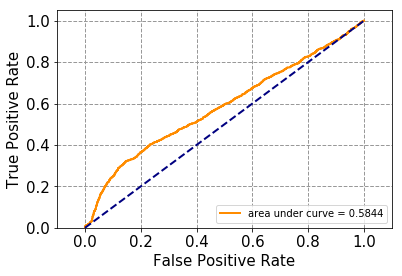

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
predicted_test_label = clf3.predict(test_nmf_data)

print "Accuracy: ", smet.accuracy_score(y_test, predicted_test_label)
print "Recall: ", smet.recall_score(y_test, predicted_test_label)
print "Precision: ", smet.precision_score(y_test, predicted_test_label)
print "Confusion matrix: ", smet.confusion_matrix(y_test, predicted_test_label)
print "F1 score: ", smet.f1_score(y_test, predicted_test_label)

fit_predict_and_plot_roc(clf3, train_nmf_data, y_train, test_nmf_data, y_test, prob_score)

## Second model v2: Naive bayes BernoulliNB with SVD ##

Accuracy:  0.621159754224
Recall:  0.693302387268
Precision:  0.66613571201
Confusion matrix:  [[1144 1048]
 [ 925 2091]]
F1 score:  0.679447603574


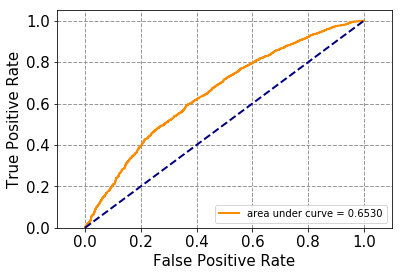

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB # BernoulliNB
from sklearn.naive_bayes import BernoulliNB
clf3 = BernoulliNB().fit(train_svd_data, y_train)
prob_score = clf3.predict_proba(test_svd_data)
predicted_test_label = clf3.predict(test_svd_data)

print "Accuracy: ", smet.accuracy_score(y_test, predicted_test_label)
print "Recall: ", smet.recall_score(y_test, predicted_test_label)
print "Precision: ", smet.precision_score(y_test, predicted_test_label)
print "Confusion matrix: ", smet.confusion_matrix(y_test, predicted_test_label)
print "F1 score: ", smet.f1_score(y_test, predicted_test_label)

fit_predict_and_plot_roc(clf3, train_svd_data, y_train, test_svd_data, y_test, prob_score)

## Third model: Logistic regression with regularization term l2 SVD ##

logistic regression with regularization term l2: 
cstrength:  10000
Accuracy:  0.666282642089
Recall:  0.901856763926
Precision:  0.65353195579
Confusion matrix:  [[ 750 1442]
 [ 296 2720]]
F1 score:  0.525865580448


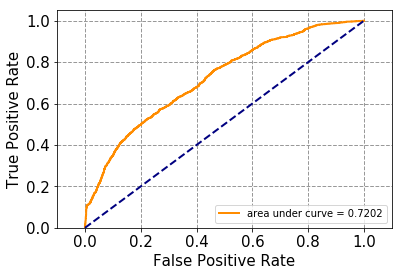

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
from sklearn import linear_model
# cstrength = []
# for k in range(-3, 5):
#     cstrength.append((10**k))
print "logistic regression with regularization term l2: "

logistic = linear_model.LogisticRegression(penalty='l2', C = 0.001)
logistic.fit(train_svd_data, y_train)
predicted_lr_label = logistic.predict(test_svd_data)
print "cstrength: ", c
print "Accuracy: ", smet.accuracy_score(y_test, predicted_lr_label)
print "Recall: ", smet.recall_score(y_test, predicted_lr_label)
print "Precision: ", smet.precision_score(y_test, predicted_lr_label)
print "Confusion matrix: ", smet.confusion_matrix(y_test, predicted_lr_label)
print "F1 score: ", smet.f1_score(y_test, predicted_test_label)
prob_score = logistic.predict_proba(test_svd_data)
fit_predict_and_plot_roc(logistic, train_svd_data, y_train, test_svd_data, y_test, prob_score)


## Forth model: Random Forest ##

Accuracy:  0.626728110599
Recall:  0.790450928382
Precision:  0.645021645022
Confusion matrix:  [[ 880 1312]
 [ 632 2384]]
F1 score:  0.710369487485


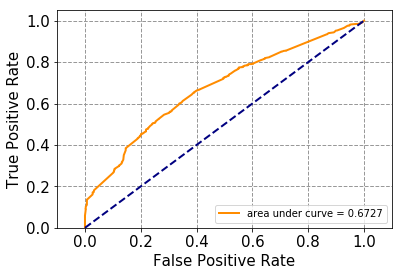

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf3 = RandomForestClassifier(max_depth=2, random_state=0)
clf3.fit(train_svd_data, y_train)
prob_score = clf3.predict_proba(test_svd_data)
predicted_test_label = clf3.predict(test_svd_data)

print "Accuracy: ", smet.accuracy_score(y_test, predicted_test_label)
print "Recall: ", smet.recall_score(y_test, predicted_test_label)
print "Precision: ", smet.precision_score(y_test, predicted_test_label)
print "Confusion matrix: ", smet.confusion_matrix(y_test, predicted_test_label)
print "F1 score: ", smet.f1_score(y_test, predicted_test_label)

fit_predict_and_plot_roc(clf3, train_svd_data, y_train, test_svd_data, y_test, prob_score)

## Fifth model: decision tree ##

Accuracy:  0.573732718894
Recall:  0.602453580902
Precision:  0.640239605356
Confusion matrix:  [[1171 1021]
 [1199 1817]]
F1 score:  0.620772121626


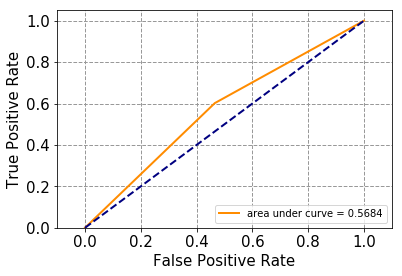

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [30]:
from sklearn.tree import DecisionTreeClassifier
clf3 = DecisionTreeClassifier(random_state=0)
clf3.fit(train_svd_data, y_train)
prob_score = clf3.predict_proba(test_svd_data)
predicted_test_label = clf3.predict(test_svd_data)

print "Accuracy: ", smet.accuracy_score(y_test, predicted_test_label)
print "Recall: ", smet.recall_score(y_test, predicted_test_label)
print "Precision: ", smet.precision_score(y_test, predicted_test_label)
print "Confusion matrix: ", smet.confusion_matrix(y_test, predicted_test_label)
print "F1 score: ", smet.f1_score(y_test, predicted_test_label)

fit_predict_and_plot_roc(clf3, train_svd_data, y_train, test_svd_data, y_test, prob_score)